In [1]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

plt.rcParams["font.family"] = "Arial"

In [2]:
def sdk_test_collection(sdk_name):
    """Collects transpile test results in CQD for a specified SDK

    Parameters:
        sdk_name (str): Valid names are: 'bqskit', 'qiskit', 'service', 'staq', and 'tket'

    Returns:
        dict: Dictionary of results collected from all input files in CWD
    """
    temp_results = {'test_status_counts': {},
                   'benchmarks': {},
                   'failed' : {},
                   'xfailed' : {}}
    files = os.listdir(os.curdir)
    for file in files:
        if sdk_name in file:
            with open(file) as f:
                temp_dict = json.load(f)
                for key, val in temp_dict['test_status_counts'].items():
                    if key in temp_results['test_status_counts']:
                        temp_results['test_status_counts'][key] += val
                    else:
                        temp_results['test_status_counts'][key] = val
                
                for benchmark in temp_dict['benchmarks']:
                    temp_results['benchmarks'][benchmark['name']] = {}
                    temp_results['benchmarks'][benchmark['name']]['group'] = benchmark['group']
                    temp_results['benchmarks'][benchmark['name']]['time'] = benchmark['stats']['mean']
                    temp_results['benchmarks'][benchmark['name']]['extra_info'] = benchmark['extra_info']

                for benchmark, vals in temp_dict['test_dumps']['failed'].items():
                    temp_results['failed'][benchmark] = vals

                # Need this because Tket device data was using older pytest-benchmark wrapper
                for benchmark, vals in temp_dict['test_dumps']['xfailed'].items():
                     temp_results['xfailed'][benchmark] = vals

    return temp_results

In [3]:
bqskit_results = sdk_test_collection('bqskit')
braket_results = sdk_test_collection('braket')
cirq_results = sdk_test_collection('cirq')
qiskit_results = sdk_test_collection('qiskit')
tket_results = sdk_test_collection('tket')

results = [bqskit_results, braket_results, cirq_results, qiskit_results, tket_results]

In [4]:
def get_qiskit_results(qiskit_results, kind='construction'):
    build_test_name = []
    build_test_time = []

    for res, val in qiskit_results['benchmarks'].items():
        if kind in val['group']:
            build_test_name.append(res)
            build_test_time.append(val['time'])

    qiskit_names, qiskit_times = (list(x) for x in zip(*sorted(zip(build_test_name, build_test_time),
                                                               key=lambda pair: -pair[1])))
    return build_test_name, build_test_time

def get_sdk_results(sdk_results, qiskit_test_names):
    sdk_times = []
    for name in qiskit_test_names:
        if name in sdk_results['benchmarks']:
            sdk_times.append(sdk_results['benchmarks'][name]['time'])
        else:
            other_val = -1
            for sdk_name in sdk_results['failed']:
                if sdk_name.split('::')[2] == name:
                    other_val = -2
            if 'xfailed' in sdk_results:
                for sdk_name in sdk_results['xfailed']:
                    if sdk_name.split('::')[2] == name:
                        other_val = -3
            sdk_times.append(other_val)
    return sdk_times

In [5]:
qiskit_const_names, qiskit_const_times = get_qiskit_results(qiskit_results, 'construction')
bqskit_const_times = get_sdk_results(bqskit_results, qiskit_const_names)
braket_const_times = get_sdk_results(braket_results, qiskit_const_names)
cirq_const_times = get_sdk_results(cirq_results, qiskit_const_names)
tket_const_times = get_sdk_results(tket_results, qiskit_const_names)

In [6]:
qiskit_const_names

['test_QV100_build',
 'test_DTC100_set_build',
 'test_multi_control_circuit',
 'test_clifford_build',
 'test_param_circSU2_100_build',
 'test_param_circSU2_100_bind',
 'test_QV100_qasm2_import',
 'test_bigint_qasm2_import']

In [7]:
qiskit_const_times

[0.05945824774244102,
 0.07094943717432518,
 0.00028494428379171704,
 1.099061956978403,
 0.010231447369870642,
 0.0015185242343498182,
 0.7575283304904588,
 0.0015552432002860874]

In [8]:
0.02023844270939555/0.0015

13.492295139597035

In [9]:
sum(braket_const_times)

11.636934495369353

In [10]:
sum([q for q in bqskit_const_times if q >0])

50.9436850822212

In [11]:
bqskit_const_times

[0.38673441697998595,
 30.63430444803089,
 -3,
 1.7080729189910926,
 0.012809874694953165,
 0.028923083519514062,
 18.172840340004768,
 -2]

In [12]:
sum([q for q in tket_const_times if q >0])

14.225834158172104

In [13]:
cirq_const_times

[0.7611142380046658,
 0.0012627236608743133,
 0.00031789609323228525,
 1.6376324219745584,
 0.024977910517783905,
 0.02023844270939555,
 12.13940578600159,
 0.005811088136397302]

In [14]:
sum([q for q in cirq_const_times if q >0])

14.590760507098496

In [15]:
qiskit_manip_names, qiskit_manip_times = get_qiskit_results(qiskit_results, 'manipulation')
bqskit_manip_times = get_sdk_results(bqskit_results, qiskit_manip_names)
braket_manip_times = get_sdk_results(braket_results, qiskit_manip_names)
cirq_manip_times = get_sdk_results(cirq_results, qiskit_manip_names)
tket_manip_times = get_sdk_results(tket_results, qiskit_manip_names)

In [16]:
0.111/0.0409

2.7139364303178484

In [17]:
qiskit_manip_times

[0.11137892659753561,
 1.8735688189626671,
 3.4769794280291535,
 0.008823016326100197]

In [18]:
sum([q for q in tket_manip_times if q >0])

7.087841764839443

In [19]:
color_set = ['#0075C3', '#ee7733', '#6929c4', '#009988', '#cc3311', '#33bbee', '#ee3377']

qiskit_color = '#6929c4'
bqskit_color = '#0075C3'
tket_color = '#ee7733'
cirq_color = '#cc3311'
braket_color = '#33bbee'

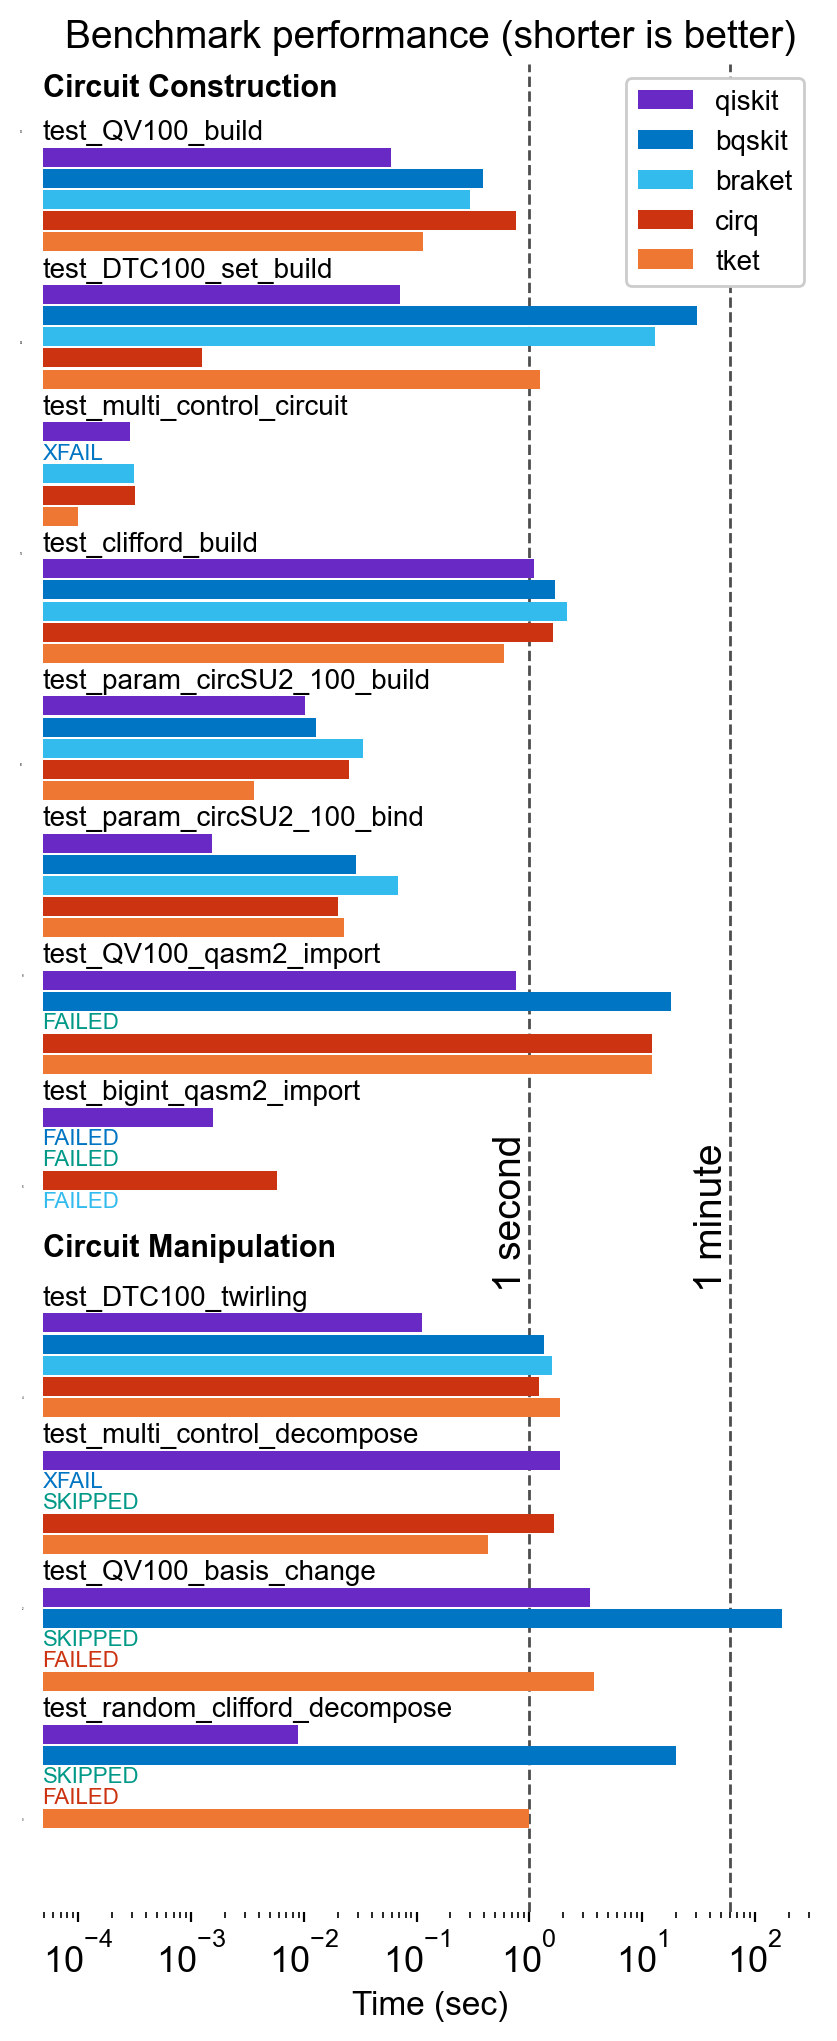

In [20]:
fig, ax = plt.subplots(figsize=(5,12))

num_manip_steps = np.arange(len(qiskit_manip_times))

ax.barh(num_manip_steps+0.8+0.3*num_manip_steps, qiskit_manip_times[::-1], height=0.18,
        color=qiskit_color, label='qiskit', zorder=2)
ax.barh(num_manip_steps+0.60+0.3*num_manip_steps, bqskit_manip_times[::-1], height=0.18,
        color=bqskit_color, label='bqskit', zorder=2)
ax.barh(num_manip_steps+0.40+0.3*num_manip_steps, braket_manip_times[::-1], height=0.18,
        color=braket_color, label='braket', zorder=2)
ax.barh(num_manip_steps+0.20+0.3*num_manip_steps, cirq_manip_times[::-1], height=0.18,
        color=cirq_color, label='cirq', zorder=2)
ax.barh(num_manip_steps+0.0+0.3*num_manip_steps, tket_manip_times[::-1], height=0.18,
        color=tket_color, label='tket', zorder=2)

offset = len(num_manip_steps)+0.5

num_build_steps = np.arange(len(qiskit_const_times)) +offset
ax.barh(num_build_steps+0.8+0.3*num_build_steps, qiskit_const_times[::-1], height=0.18,
        color=qiskit_color, zorder=2)
ax.barh(num_build_steps+0.60+0.3*num_build_steps, bqskit_const_times[::-1], height=0.18,
        color=bqskit_color, zorder=2)
ax.barh(num_build_steps+0.40+0.3*num_build_steps, braket_const_times[::-1], height=0.18,
        color=braket_color, zorder=2)
ax.barh(num_build_steps+0.20+0.3*num_build_steps, cirq_const_times[::-1], height=0.18,
        color=cirq_color, zorder=2)
ax.barh(num_build_steps+0.0+0.3*num_build_steps, tket_const_times[::-1], height=0.18,
        color=tket_color, zorder=2)
ax.set_xscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title('Benchmark performance (shorter is better)', fontsize=14)

ax.axvline(1, zorder=1, lw=1, linestyle='dashed', color='0.3')

ax.axvline(60, zorder=1, lw=1, linestyle='dashed', color='0.3')


for idx, val in enumerate(num_manip_steps+0.60+0.3*num_manip_steps):
    if bqskit_manip_times[::-1][idx] == -1:
        ax.annotate('SKIPPED', (ax.get_xlim()[0], val), color=color_set[0], fontsize=8, va='center')
    elif bqskit_manip_times[::-1][idx] == -2:
        ax.annotate('FAILED', (ax.get_xlim()[0], val), color=color_set[0], fontsize=8, va='center')
    elif bqskit_manip_times[::-1][idx] == -3:
        ax.annotate('XFAIL', (ax.get_xlim()[0], val), color=color_set[0], fontsize=8, va='center')

for idx, val in enumerate(num_build_steps+0.60+0.3*num_build_steps):
    if bqskit_const_times[::-1][idx] == -1:
        ax.annotate('SKIPPED', (ax.get_xlim()[0], val), color=color_set[0], fontsize=8, va='center')
    elif bqskit_const_times[::-1][idx] == -2:
        ax.annotate('FAILED', (ax.get_xlim()[0], val), color=color_set[0], fontsize=8, va='center')
    elif bqskit_const_times[::-1][idx] == -3:
        ax.annotate('XFAIL', (ax.get_xlim()[0], val), color=color_set[0], fontsize=8, va='center')

for idx, val in enumerate(num_manip_steps+0.40+0.3*num_manip_steps):
    if braket_manip_times[::-1][idx] == -1:
        ax.annotate('SKIPPED', (ax.get_xlim()[0], val), color=color_set[3], fontsize=8, va='center')
    elif braket_manip_times[::-1][idx] == -2:
        ax.annotate('FAILED', (ax.get_xlim()[0], val), color=color_set[3], fontsize=8, va='center')
    elif braket_manip_times[::-1][idx] == -3:
        ax.annotate('XFAIL', (ax.get_xlim()[0], val), color=color_set[3], fontsize=8, va='center')

for idx, val in enumerate(num_build_steps+0.40+0.3*num_build_steps):
    if braket_const_times[::-1][idx] == -1:
        ax.annotate('SKIPPED', (ax.get_xlim()[0], val), color=color_set[3], fontsize=8, va='center')
    elif braket_const_times[::-1][idx] == -2:
        ax.annotate('FAILED', (ax.get_xlim()[0], val), color=color_set[3], fontsize=8, va='center')
    elif braket_const_times[::-1][idx] == -3:
        ax.annotate('XFAIL', (ax.get_xlim()[0], val), color=color_set[3], fontsize=8, va='center')

for idx, val in enumerate(num_manip_steps+0.20+0.3*num_manip_steps):
    if cirq_manip_times[::-1][idx] == -1:
        ax.annotate('SKIPPED', (ax.get_xlim()[0], val), color=color_set[4], fontsize=8, va='center')
    elif cirq_manip_times[::-1][idx] == -2:
        ax.annotate('FAILED', (ax.get_xlim()[0], val), color=color_set[4], fontsize=8, va='center')
    elif cirq_const_times[::-1][idx] == -3:
        ax.annotate('XFAIL', (ax.get_xlim()[0], val), color=color_set[4], fontsize=8, va='center')

for idx, val in enumerate(num_build_steps+0.20+0.3*num_build_steps):
    if cirq_const_times[::-1][idx] == -1:
        ax.annotate('SKIPPED', (ax.get_xlim()[0], val), color=color_set[4], fontsize=8, va='center')
    elif cirq_const_times[::-1][idx] == -2:
        ax.annotate('FAILED', (ax.get_xlim()[0], val), color=color_set[4], fontsize=8, va='center')
    elif cirq_const_times[::-1][idx] == -3:
        ax.annotate('XFAIL', (ax.get_xlim()[0], val), color=color_set[4], fontsize=8, va='center')


for idx, val in enumerate(num_manip_steps+0.0+0.3*num_manip_steps):
    if tket_manip_times[::-1][idx] == -1:
        ax.annotate('SKIPPED', (ax.get_xlim()[0], val), color=color_set[5], fontsize=8, va='center')
    elif tket_manip_times[::-1][idx] == -2:
        ax.annotate('FAILED', (ax.get_xlim()[0], val), color=color_set[5], fontsize=8, va='center')
    elif tket_const_times[::-1][idx] == -3:
        ax.annotate('XFAIL', (ax.get_xlim()[0], val), color=color_set[5], fontsize=8, va='center')

for idx, val in enumerate(num_build_steps+0.0+0.3*num_build_steps):
    if tket_const_times[::-1][idx] == -1:
        ax.annotate('SKIPPED', (ax.get_xlim()[0], val), color=color_set[5], fontsize=8, va='center')
    elif tket_const_times[::-1][idx] == -2:
        ax.annotate('FAILED', (ax.get_xlim()[0], val), color=color_set[5], fontsize=8, va='center')
    elif tket_const_times[::-1][idx] == -3:
        ax.annotate('XFAIL', (ax.get_xlim()[0], val), color=color_set[5], fontsize=8, va='center')




for idx, name in enumerate(qiskit_manip_names[::-1]):
    ax.annotate(name, (ax.get_xlim()[0], idx+0.97+0.3*idx), color='k', fontsize=10)

for idx, name in enumerate(qiskit_const_names[::-1]):
    idx += 4.5
    ax.annotate(name, (ax.get_xlim()[0], idx+0.97+0.3*idx), color='k', fontsize=10)

for tick in ax.get_yticklines():
    tick.set_visible(False)
for xlabel_i in ax.get_yticklabels():
    xlabel_i.set_fontsize(0.0)

ax.annotate('Circuit Manipulation', (ax.get_xlim()[0], len(num_manip_steps)+1.33), color='k', fontsize=11, fontweight='bold')
ax.annotate('Circuit Construction', (ax.get_xlim()[0], 16.33), color='k', fontsize=11, fontweight='bold')

ax.tick_params(axis='x', which='major', labelsize=13)
ax.tick_params(axis='x', which='minor', labelsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
legend = ax.legend(fontsize=10, loc=1)
legend.get_frame().set_alpha(None)

ax.annotate('1 second', (1, 5), fontsize=14, horizontalalignment='right', verticalalignment='bottom', rotation=90)
ax.annotate('1 minute', (60, 5), fontsize=14, horizontalalignment='right', verticalalignment='bottom', rotation=90);

In [21]:
fig.tight_layout()
fig.savefig('construct_and_manipulate.pdf')

In [55]:
bqskit_results

{'test_status_counts': {'passed': 9, 'failed': 1, 'xfailed': 2, 'skipped': 0},
 'benchmarks': {'test_DTC100_twirling': {'group': 'Circuit manipulation',
   'time': 1.3624374150531366,
   'extra_info': {'qasm_load_time': 3.1695875960285775,
    'input_num_qubits': 100}},
  'test_QV100_basis_change': {'group': 'Circuit manipulation',
   'time': 175.62245762598468,
   'extra_info': {'qasm_load_time': 17.861516271019354,
    'input_num_qubits': 100}},
  'test_random_clifford_decompose': {'group': 'Circuit manipulation',
   'time': 20.178779592970386,
   'extra_info': {'gate_count_2q': 2350, 'depth_2q': 698}},
  'test_QV100_build': {'group': 'Circuit construction',
   'time': 0.38673441697998595,
   'extra_info': {}},
  'test_DTC100_set_build': {'group': 'Circuit construction',
   'time': 30.63430444803089,
   'extra_info': {}},
  'test_clifford_build': {'group': 'Circuit construction',
   'time': 1.7080729189910926,
   'extra_info': {}},
  'test_param_circSU2_100_build': {'group': 'Circuit

In [25]:
qiskit_results['test_status_counts']

{'passed': 12, 'failed': 0, 'xfailed': 0, 'skipped': 0}

In [26]:
tket_results['test_status_counts']

{'passed': 11, 'failed': 1, 'xfailed': 0, 'skipped': 0}

In [27]:
bqskit_results['test_status_counts']

{'passed': 9, 'failed': 1, 'xfailed': 2, 'skipped': 0}

In [28]:
braket_results['test_status_counts']

{'passed': 7, 'failed': 2, 'xfailed': 0, 'skipped': 3}

In [29]:
cirq_results['test_status_counts']

{'passed': 10, 'failed': 2, 'xfailed': 0, 'skipped': 0}